In [42]:
import math
import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

from matplotlib.lines import Line2D
from matplotlib import markers
from matplotlib.cm import get_cmap
from matplotlib.gridspec import GridSpec

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')


# Constants

In [22]:
data_path = 'datasets/dataset.csv'

cmap = get_cmap('Set2')
cmap_paired = get_cmap('Paired')

sns.set(style="whitegrid", font_scale=1)

experiment_dict = {
    'experiment_source_code': 'Source code',
    'experiment_exp_source_code': 'Experiment\n source code',
    'experiment_external_source_code': 'External\n source code', 
    'experiment_hw': 'Hardware', 
    'experiment_runtime': 'Runtime',
    'experiment_setup': 'Setup',
    'experiment_params': 'Params\n value',
}

data_dict = {
    'data_experiment': 'Dataset', 
    'data_ground_truth': 'Ground\n truth',
    'data_params': 'Export\n parameters',
    'data_version': 'Version'
}

method_dict = {
    'method_contribution': 'Research\n questions',
    'method_objective': 'Objective',
    'method_problem': 'Problem',
    'method_research': 'Research\n methodology', 
    'method_pseudo_code': 'Pseudo-code',
    'method_params_description': 'Params\n description'
}


m_d = {i:item[1] for i, item in enumerate(method_dict.items())}
d_d = {i:item[1] for i, item in enumerate(data_dict.items())}
e_d = {i:item[1] for i, item in enumerate(experiment_dict.items())}

# Helper functions

In [40]:
interval = [2000, 2010, 2020]
ranges = [0, 0.5, 0.99, 1]

### Helper function for plot 5.3
def plot_per_task(dataframe, axs, axis_nr, axis_off=False):
    
    repro_types = ['method', 'data', 'experiment']
    
    for i, t in enumerate(repro_types):
        df = pd.melt(dataframe[dataframe['repro'] == t].drop(['repro', 'N/A'], axis=1), ['variable'],
                     value_vars=[True, False], value_name='count').pivot(index='value', 
                                            columns='variable')['count'].reset_index()

        y_pos = list(df.columns[1:])
        axs[i][axis_nr].barh(y_pos, -df.iloc[0, 1:], color=cmap_paired(4), height=height)
        axs[i][axis_nr].barh(y_pos, df.iloc[1, 1:], color=cmap(0), height=height)
        axs[i][axis_nr].set_ylim([-0.5, len(y_pos)-0.5])
        axs[i][axis_nr].set_yticklabels(y_pos)
    
        for j, v in enumerate(df.iloc[0, 1:].to_numpy()):
            if math.isnan(v) or math.isnan(j):
                continue
            axs[i][axis_nr].text(-round(v) - 70, j, '{:.0f}%'.format(v), fontdict={'fontsize': 'medium'})

        for j, v in enumerate(df.iloc[1, 1:].to_numpy()):
            if math.isnan(v) or math.isnan(j):
                continue
            axs[i][axis_nr].text(round(v) + 7, j, '{:.0f}%'.format(v), fontdict={'fontsize': 'medium'})
    
        for ax in axs:
            ax[axis_nr].set_xlim([-180, 180])
            ax[axis_nr].set_xticks([])

        if axis_off:
            for ax in axs:
                ax[axis_nr].set_yticks([])


### Helper functions for plot 5.4
def append_column_true_values(dataframe, append_to, column_name): 
    aux = dataframe.groupby([column_name, 'year']).count()['number'].reset_index()
    
    return append_to.append(aux[aux[column_name] == True])
    
    
def plot_variable_percentage_intervals_horizontal(dataframe, columns, y_pos_dict, ax, interval=interval):
    aux = pd.DataFrame()

    for c in columns:
        aux = append_column_true_values(dataframe, aux, c)
        
    
    aux_plot = pd.melt(aux, ['year', 'number']).dropna().drop(['value'], axis=1).pivot(index='year', columns='variable')['number'].reset_index()
    
    aux_split_interval = aux_plot.groupby([pd.cut(aux_plot['year'], interval)]).sum()[columns]
    aux_split_interval.iloc[0] = aux_split_interval.iloc[0].transform(lambda x: x * 10)
    aux_split_interval.iloc[1] = aux_split_interval.iloc[1].transform(lambda x: x * 100 / 18)
    aux_split_interval.reset_index(inplace=True)
    
    y_pos = range(0, aux_split_interval.shape[1]-1)
    
    height = 0.7
    
    ax.barh(y_pos, -aux_split_interval.iloc[0, 1:], color=cmap_paired(8), height=height)
    ax.barh(y_pos, aux_split_interval.iloc[1, 1:], color=cmap_paired(6), height=height)

    ax.set_yticks(y_pos)
    ax.set_yticklabels(y_pos_dict.values(), fontdict={'fontsize': 'medium'})
    
    for i, v in enumerate(aux_split_interval.iloc[0, 1:].to_numpy()):
        ax.text(-v - 50, i, '{:.1f}%'.format(v), fontdict={'fontsize': 'medium'})

    for i, v in enumerate(aux_split_interval.iloc[1, 1:].to_numpy()):
        ax.text(v + 7, i, '{:.1f}%'.format(v), fontdict={'fontsize': 'medium'})

    ax.set_xlim([-155, 160])
    ax.set_xticklabels([])
    ax.grid(False)
    
    return ax


# Data

In [38]:
df = pd.read_csv(data_path).drop(['D_REPRO_CHECK', 'M_REPRO_CHECK', 'E_REPRO_CHECK'], axis=1)
df = df.replace('PVLDB', 'VLDB')
df = df.replace('TKDD', 'KDD')
df = df.drop(df[df['venue'] == 'CIDR'].index)

grouped_df = df.drop(['number', 'year', 'venue', 'method_repro', 'data_repro', 'experiment_repro', 'experiment_results'], axis=1)
grouped_df = pd.melt(grouped_df, ['name', 'task'])
grouped_df['value'] = grouped_df['value'].fillna('N/A')
grouped_df['repro'] = grouped_df['variable']
grouped_df['repro'] = grouped_df['repro'].replace(to_replace=r'^data_.*$', value='data', regex=True)
grouped_df['repro'] = grouped_df['repro'].replace(to_replace=r'^method_.*$', value='method', regex=True)
grouped_df['repro'] = grouped_df['repro'].replace(to_replace=r'^experiment_.*$', value='experiment', regex=True)
grouped_df = grouped_df.groupby(['task', 'variable', 'repro', 'value'])['name'].aggregate('count').unstack().reset_index()

### Data for plot 5.1
grouped_by_year = df.groupby(['year', 'task'])['name'].aggregate('count').unstack().fillna(0).reset_index()
grouped_by_venue = df.groupby(['venue', 'task'])['name'].aggregate('count').unstack().fillna(0).reset_index()
###

### Data for plot 5.2
pie_data = df.groupby('task')['name'].aggregate('count').reset_index()
pie_data['task'] = pie_data['task'].apply(lambda x: d[x])
pie_data = pie_data.set_index('task').iloc[:,0]
###

### Data for plot 5.3
task_count = df.groupby('task').count()['name']

em = grouped_df[grouped_df['task'] == 'EM'].drop(['task'], axis=1)
er = grouped_df[grouped_df['task'] == 'ER'].drop(['task'], axis=1)
smap = grouped_df[grouped_df['task'] == 'SMAP'].drop(['task'], axis=1)
smat = grouped_df[grouped_df['task'] == 'SMAT'].drop(['task'], axis=1)

em_aux = em.copy()
em_aux[True] = em_aux[True].apply(lambda x: x * 100 / task_count['EM'])
em_aux[False] = em_aux[False].apply(lambda x: x * 100 / task_count['EM'])

er_aux = er.copy()
er_aux[True] = er_aux[True].apply(lambda x: x * 100 / task_count['ER'])
er_aux[False] = er_aux[False].apply(lambda x: x * 100 / task_count['ER'])

smat_aux = smat.copy()
smat_aux[True] = smat_aux[True].apply(lambda x: x * 100 / task_count['SMAT'])
smat_aux[False] = smat_aux[False].apply(lambda x: x * 100 / task_count['SMAT'])

smap_aux = smap.copy()
smap_aux[True] = smap_aux[True].apply(lambda x: x * 100 / task_count['SMAP'])
smap_aux[False] = smap_aux[False].apply(lambda x: x * 100 / task_count['SMAP'])
### 


# Plots

## Distribution of tasks per year and venue

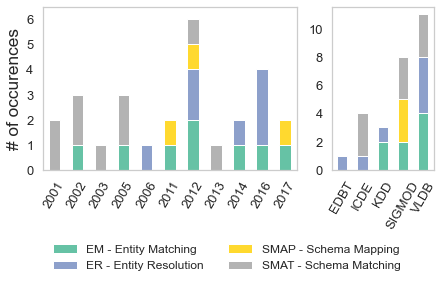

In [39]:

fontsize=15

fig = plt.figure(figsize=(7, 3))
fig.subplots_adjust(wspace=0.2)

cols = 2
rows = 1

spec = GridSpec(ncols=cols, nrows=rows, width_ratios=[2.5, 1])

axs = list()
axs.append(fig.add_subplot(spec[0]))
axs.append(fig.add_subplot(spec[1]))

axis1 = grouped_by_year.plot(x='year', kind='bar', stacked=True, ax=axs[0], 
                             fontsize=13, colormap=cmap)
axis1.grid(False)
axis1.set_ylim([0, 6.5])
axis1.set_xlabel('')
axis1.set_ylabel('# of occurences', fontsize='x-large')
axis1.set_xticklabels(axis1.get_xticklabels(), rotation='60')
axis1.set_axisbelow(True)
axis1.get_legend().remove()


axis2 = grouped_by_venue.plot(x='venue', kind='bar', stacked=True, ax=axs[1], 
                              fontsize=13, colormap=cmap, width=0.5)
axis2.grid(False)
axis2.set_xlabel('')
axis2.set_xticklabels(axis2.get_xticklabels(), rotation='60')
axis2.set_yticks(range(0, 12, 2))
axis2.set_axisbelow(True)

h, l = axis2.get_legend_handles_labels()
labels = ['EM - Entity Matching', 'ER - Entity Resolution', 'SMAP - Schema Mapping', 'SMAT - Schema Matching']
axis2.legend(h, labels, loc=(-2.8, -0.65), ncol=2, fontsize='medium', frameon=False)

plt.savefig('plots/distribution-venue-year.pdf', dpi=300, bbox_inches = "tight")


## Distribution of papers per task

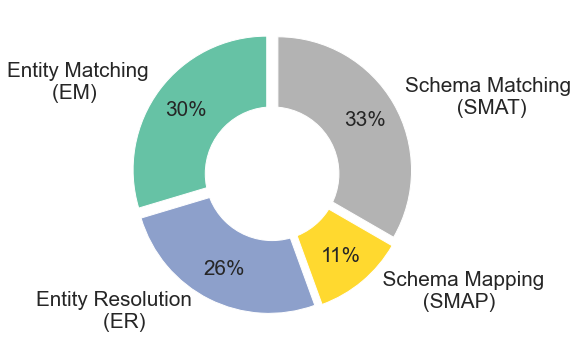

In [37]:
d = {
    'EM': 'Entity Matching\n(EM)         ',
    'ER': 'Entity Resolution  \n(ER)          ',
    'SMAT': 'Schema Matching\n         (SMAT)',
    'SMAP': '  Schema Mapping\n         (SMAP)'
}

plt.figure(figsize=(25, 5))

explode = (0.05,0.05,0.05,0.05)

axis = pie_data.plot.pie(autopct='%1.0f%%', colormap=cmap, fontsize='xx-large',
                         startangle=90, pctdistance=0.75, explode=explode, textprops={'fontweight': 550})

centre_circle = plt.Circle((0,0),0.50,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.tight_layout()

axis.set_ylabel('')

plt.savefig('plots/distribution-papers.pdf', dpi=300, bbox_inches = "tight")


## The percentage of true and false values for each variable per total number of papers in a task

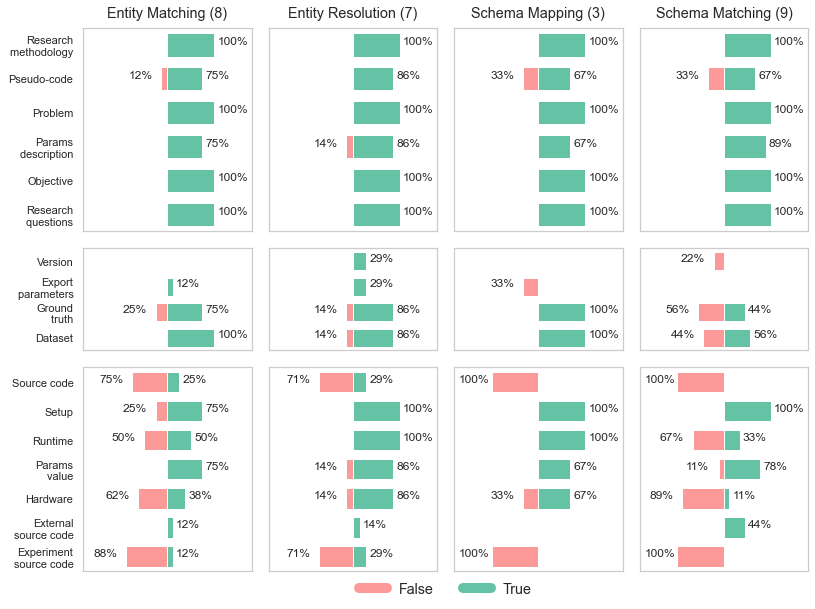

In [35]:
height = 0.7
sns.set_style({'axes.grid': False})
    
fig = plt.figure(figsize=(13, 10))
fig.subplots_adjust(wspace=0.1, hspace=0.1)

cols = 4
rows = 3
ylabel_font = 13

spec = GridSpec(ncols=cols, nrows=rows, width_ratios=[2, 2, 2, 2], height_ratios=[2, 1, 2])

axs = list()
for i in range(0, cols * rows, cols):
    ax = list()
    for j in range(i, i + cols):
        ax.append(fig.add_subplot(spec[j]))
    axs.append(ax)

plot_per_task(em_aux, axs, 0)
plot_per_task(er_aux, axs, 1, True)
plot_per_task(smat_aux, axs, 3, True)
plot_per_task(smap_aux, axs, 2, True)

axs[0][0].set_yticklabels([method_dict[x.get_text()] for x in axs[0][0].get_yticklabels()],
                          fontdict={'fontsize': 11})       
axs[1][0].set_yticklabels([data_dict[x.get_text()] for x in axs[1][0].get_yticklabels()], 
                          fontdict={'fontsize': 11})
axs[2][0].set_yticklabels([experiment_dict[x.get_text()] for x in axs[2][0].get_yticklabels()],
                          fontdict={'fontsize': 11})

title_padding = 10
axs[0][0].set_title('Entity Matching ({})'.format(task_count['EM']), fontsize='large',pad=title_padding)
axs[0][1].set_title('Entity Resolution ({})'.format(task_count['ER']), fontsize='large', pad=title_padding)
axs[0][3].set_title('Schema Matching ({})'.format(task_count['SMAT']), fontsize='large', pad=title_padding)
axs[0][2].set_title('Schema Mapping ({})'.format(task_count['SMAP']), fontsize='large', pad=title_padding)

plt.legend(handles=[Line2D([], [], color= cmap_paired(4), linestyle='-', linewidth=10, label='False'),
                   Line2D([], [], color= cmap(0), linestyle='-', linewidth=10, label='True')],
                ncol=2, loc=(-1.7, -0.15), fontsize='large', frameon=False)

plt.savefig('plots/distribution-task-variable.pdf', dpi=300, bbox_inches='tight')




## The percentage of papers with true values for each variable per total number of papers in a year interval

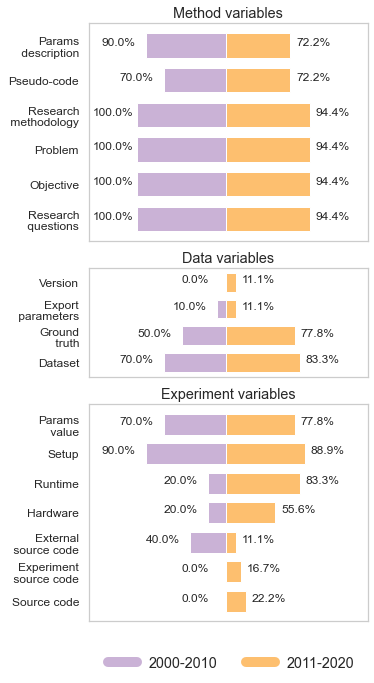

In [49]:

fig = plt.figure(figsize=(5, 11))
fig.subplots_adjust(hspace=0.15)

cols = 1
rows = 3

spec = GridSpec(ncols=cols, nrows=rows, width_ratios=[1], height_ratios=[1, 0.5, 1])

axs = list()
for i in range(0, cols * rows, cols):
    axs.append(fig.add_subplot(spec[i]))

plot_variable_percentage_intervals_horizontal(df, method_dict.keys(), m_d, axs[0])
plot_variable_percentage_intervals_horizontal(df, data_dict.keys(), d_d, axs[1])
plot_variable_percentage_intervals_horizontal(df, experiment_dict.keys(), e_d, axs[2])

axs[0].set_title('Method variables', fontsize='large')
axs[1].set_title('Data variables', fontsize='large')
axs[2].set_title('Experiment variables', fontsize='large')


plt.legend(handles=[Line2D([], [], color= cmap_paired(8), linestyle='-', linewidth=10, label='2000-2010'),
                   Line2D([], [], color= cmap_paired(6), linestyle='-', linewidth=10, label='2011-2020')],
                ncol=4, loc=(0.05, -0.25), fontsize='large', frameon=False)


plt.savefig('plots/diverging-variables.pdf', dpi=300, bbox_inches='tight')



# Statistics

## General statistics

In [19]:
columns = ['data_experiment', 'data_ground_truth', 'data_version',
                'experiment_source_code', 'experiment_external_source_code',
               'experiment_exp_source_code', 'experiment_hw', 'experiment_runtime', 'experiment_setup',
               'experiment_params', 'method_params_description']

stats = df[columns].fillna('N/A')
# Added extra column outside the index and set the index to all the columns for the count function
stats = stats.assign(occr='').set_index(columns)

# New dataset to store the percentages 
pctg_code_data = pd.DataFrame(columns=columns)
# Added a new index with the boolean values and 'N/A'
pctg_code_data = pctg_code_data.assign(value=[True, False, 'N/A']).set_index('value')

cols = pctg_code_data.columns
# count the values for each column and store it in the new df
for col in cols:
    pctg_code_data.loc[:, col] = stats.count(level=col)['occr'] 

# Transform in percentage with 1 decimal
pctg_code_data = pctg_code_data.fillna(0).apply(lambda x: x * 100 / df.shape[0]).round(1)

transp = pctg_code_data.transpose().reset_index()

display(transp)
display(pctg_code_data)

value,index,True,False,N/A
0,data_experiment,81.5,18.5,0.0
1,data_ground_truth,70.4,29.6,0.0
2,data_version,7.4,7.4,85.2
3,experiment_source_code,14.8,85.2,0.0
4,experiment_external_source_code,22.2,0.0,77.8
5,experiment_exp_source_code,11.1,88.9,0.0
6,experiment_hw,44.4,55.6,0.0
7,experiment_runtime,63.0,37.0,0.0
8,experiment_setup,92.6,7.4,0.0
9,experiment_params,77.8,7.4,14.8


,data_experiment,data_ground_truth,data_version,experiment_source_code,experiment_external_source_code,experiment_exp_source_code,experiment_hw,experiment_runtime,experiment_setup,experiment_params,method_params_description
value,,,,,,,,,,,
True,81.5,70.4,7.4,14.8,22.2,11.1,44.4,63.0,92.6,77.8,81.5
False,18.5,29.6,7.4,85.2,0.0,88.9,55.6,37.0,7.4,7.4,3.7
N/A,0.0,0.0,85.2,0.0,77.8,0.0,0.0,0.0,0.0,14.8,14.8


## Statistics about R1D, R2D, R3D

In [20]:
sel = df[['method_repro', 'data_repro', 'experiment_repro']]
sel = sel.assign(interval='')

aux = interval_count(sel, 'experiment_repro')

pctg_rd = pd.DataFrame(columns=['interval', 'method_repro', 'data_repro', 'experiment_repro'])
pctg_rd.loc[:, 'interval'] = aux[1]
pctg_rd.loc[:, 'experiment_repro'] = aux[0]
pctg_rd.loc[:, 'method_repro'] = interval_count(sel, 'method_repro')[0]
pctg_rd.loc[:, 'data_repro'] = interval_count(sel, 'data_repro')[0]


display(pctg_rd)

,interval,method_repro,data_repro,experiment_repro
0,"(0.0, 0.5]",0.0,18.5,0.0
1,"(0.5, 0.99]",29.6,33.3,92.6
2,"(0.99, 1.0]",70.4,48.1,7.4


## Method, Data and Experiment stats

In [53]:
abc = df.drop(['task', 'number', 'year', 'venue', 'method_repro', 'data_repro', 'experiment_repro', 'experiment_results'], axis=1)
abc = pd.melt(abc, ['name'])
abc['value'] = abc['value'].fillna('N/A')
abc['repro'] = abc['variable']
abc['repro'] = abc['repro'].replace(to_replace=r'^data_.*$', value='data', regex=True)
abc['repro'] = abc['repro'].replace(to_replace=r'^method_.*$', value='method', regex=True)
abc['repro'] = abc['repro'].replace(to_replace=r'^experiment_.*$', value='experiment', regex=True)

abc_all = abc.groupby(['repro', 'value'])['name'].aggregate('count').unstack().reset_index()

display(abc_all)
abc_all.drop(['N/A'], axis=1, inplace=True)
abc_all_t = abc_all.set_index('repro').T


# abc_all_t = abc_all_t.transform(lambda x: x / 27 * 6, axis=1)
abc_all_t.groupby('value').aggregate({'data': lambda x: x / 108 * 100, 'method': lambda x: x / 162 * 100, 'experiment': lambda x: x / 189 * 100})



value,repro,False,True,N/A
0,data,16,46,46
1,experiment,76,88,25
2,method,6,150,6


,data,method,experiment
value,,,
False,14.814815,3.703704,40.211640
True,42.592593,92.592593,46.560847
